# Expected Points (xP) 

The expected points (xP) model is a tool used to estimate the likely outcome of a football match based on each team’s expected goals (xG). xG is a key metric in football analytics that estimates the quality of goal-scoring chances by assigning a probability of scoring from each shot taken. The main focus of the xP model is not on the final match result but on evaluating the probabilities of winning, losing, or drawing based on the chances created during the game.

Therefore, the xP model uses the Poisson distribution to simulate the number of goals each team is expected to score based on their xG. The Poisson distribution models the probability of a given number of events (in this case, goals) occurring within a fixed interval (a match) when the average event rate (xG) is known. This distribution helps calculate the probabilities for various match outcomes (win, draw, or loss) by evaluating all possible scorelines.

The model then combines these probabilities to determine the expected points (xP) a team should earn from a match, calculated as:

	•	Win Probability (P_win): The chance the team wins the match.
	•	Draw Probability (P_draw): The chance the match ends in a draw.
	•	Loss Probability (P_loss): The chance the team loses the match.

The xP value is calculated by assigning: xP = (3 x P_win) + (1 x P_draw)

This provides a more objective way to estimate team performance based on the quality of chances created and conceded. Some teams may get lucky and win despite creating fewer high-quality chances, while others may be punished despite creating better opportunities. The xP model helps highlight these discrepancies, offering a fairer assessment of performance by focusing on the likelihood of different match outcomes based on actual chances, rather than just the final result.

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt

from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen
from matplotlib.colors import LinearSegmentedColormap

import plotly.express as px

from sqlalchemy import create_engine
import pymysql
from pymysql.cursors import DictCursor
import pymysql.cursors

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve

import xgboost as xgb

from scipy.stats import poisson 

import warnings
warnings.filterwarnings('ignore')

# Query Data

The data used in this model is scraped from WhoScored and stored in a MySQL database. Data cleaning has already been extensively handled in a separate repository, ensuring that inconsistencies and errors have been addressed.

The primary database consists of event-level data, where each row represents a specific action during a match—such as a pass, shot, tackle, or any other significant aspect of the game. This level of data allows us to capture every meaningful event, enabling a comprehensive analysis of match dynamics.

In addition to the event data, a separate team-level database will be used to identify team-specific patterns. By combining both datasets, the model offers deeper insights into team performance and chance creation during matches.

In [2]:
username = 'root'          
password = ''               
host = 'localhost'         
port = '3306'              
database = 'top7_leagues' 

# Create the SQLAlchemy engine
engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')

In [3]:
query = "SELECT * FROM match_events_2023_24"
df_events = pd.read_sql(query, engine)

In [4]:
df_events.columns

Index(['id', 'match_id', 'event_id', 'minute', 'second', 'team_id',
       'player_id', 'x', 'y', 'end_x', 'end_y', 'qualifiers', 'is_touch',
       'blocked_x', 'blocked_y', 'goal_mouth_z', 'goal_mouth_y', 'is_shot',
       'card_type', 'is_goal', 'type_display_name',
       'outcome_type_display_name', 'period_display_name'],
      dtype='object')

In [5]:
df_events.head()

,id,match_id,event_id,minute,second,team_id,player_id,x,y,end_x,...,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_shot,card_type,is_goal,type_display_name,outcome_type_display_name,period_display_name
0,2602361573,1734766,3,0,0.0,54,135366,50.1,50.0,46.4,...,NaN,NaN,NaN,NaN,0,0,0,Pass,Successful,FirstHalf
1,2602361601,1734766,4,0,1.0,54,82989,46.1,49.7,31.9,...,NaN,NaN,NaN,NaN,0,0,0,Pass,Successful,FirstHalf
2,2602361647,1734766,5,0,4.0,54,125211,31.8,13.1,20.8,...,NaN,NaN,NaN,NaN,0,0,0,Pass,Successful,FirstHalf
3,2602361695,1734766,6,0,6.0,54,121456,20.8,30.8,20.1,...,NaN,NaN,NaN,NaN,0,0,0,Pass,Successful,FirstHalf
4,2602361767,1734766,7,0,9.0,54,454342,19.4,64.2,18.1,...,NaN,NaN,NaN,NaN,0,0,0,Pass,Successful,FirstHalf


The dataset consists of various columns that capture detailed event-level information during a football match. Key identifiers include id, match_id, event_id, team_id, and player_id, which link events to specific matches, teams, and players. Temporal data is represented by minute and second, while spatial information on the field is recorded with x, y, end_x, and end_y coordinates. Event details are further described by columns like qualifiers, is_touch, blocked_x, blocked_y, goal_mouth_z, goal_mouth_y, and is_shot. Outcome-related data includes card_type, is_goal and outcome_type_display_name

In [6]:
query2 = "SELECT * FROM players_info_2023_24"
df_players = pd.read_sql(query2, engine)

In [7]:
df_teams2 = pd.read_excel(r'/Users/youssefkefi/Documents/Projects/Top 7 Leagues 2024-25/WS_links_2425.xlsx', sheet_name='WS Links')

In [8]:
df_teams3 = pd.read_excel(r'/Users/youssefkefi/Documents/Projects/Top 7 Leagues 2024-25/WS_links_2425.xlsx', sheet_name='WS Links 24-25')

In [9]:
df_combined = pd.concat([df_teams2, df_teams3])
df_teams = df_combined.drop_duplicates(subset=['id'], keep='first')

In [10]:
df_teams = df_teams[['id','team','league']]

In [11]:
df_teams

,id,team,league
0,1730,Augsburg,Allemagne-Bundesliga
1,36,Bayer-Leverkusen,Allemagne-Bundesliga
2,37,Bayern-Munich,Allemagne-Bundesliga
3,109,Bochum,Allemagne-Bundesliga
4,44,Borussia-Dortmund,Allemagne-Bundesliga
...,...,...,...
112,115,Willem-II,Netherlands-Eredivisie
113,783,NAC-Breda,Netherlands-Eredivisie
129,2343,AVS-Futebol-SAD,Portugal-Liga-Portugal
130,251,Santa-Clara,Portugal-Liga-Portugal


In [12]:
league_name_mapping = {
    'Allemagne-Bundesliga': 'Bundesliga',
    'Angleterre-Premier-League': 'Premier-League',
    'Espagne-LaLiga': 'LaLiga',
    'France-Ligue-1': 'Ligue-1',
    'Italie-Serie-A': 'Serie-A',
    'Italy-Serie-A' : 'Serie-A',
    'Netherlands-Eredivisie': 'Eredivisie',
    'Portugal-Liga-Portugal': 'Liga-Portugal',
    'Germany-Bundesliga': 'Bundesliga',
    'England-Premier-League': 'Premier-League',
    'Spain-LaLiga': 'LaLiga',
    'Eredivisie': 'Eredivisie',
    'Ligue-1': 'Ligue-1',
    'Serie-A': 'Serie-A',
    'Premier-League': 'Premier-League',
}

In [13]:
# Apply the mapping to the 'league' column in df_teams2
df_teams['league'] = df_teams['league'].replace(league_name_mapping)

In [15]:
df_teams.rename(columns={'team':'team_name'},inplace=True)

In [16]:
df_teams.rename(columns={'id':'team_id'},inplace=True)

In [17]:
df_teams

,team_id,team_name,league
0,1730,Augsburg,Bundesliga
1,36,Bayer-Leverkusen,Bundesliga
2,37,Bayern-Munich,Bundesliga
3,109,Bochum,Bundesliga
4,44,Borussia-Dortmund,Bundesliga
...,...,...,...
112,115,Willem-II,Eredivisie
113,783,NAC-Breda,Eredivisie
129,2343,AVS-Futebol-SAD,Liga-Portugal
130,251,Santa-Clara,Liga-Portugal


In [18]:
leagues = df_teams.groupby('league').count()
leagues

,team_id,team_name
league,,
Bundesliga,20,20
Eredivisie,21,21
LaLiga,23,23
Liga-Portugal,21,21
Ligue-1,21,21
Premier-League,23,23
Serie-A,23,23


In [89]:
#tafsir

The df_teams DataFrame will only be used later in the analysis to merge team names with the event data, replacing team IDs with their corresponding names for easier interpretation and analysis.

# Transform Data

## Add xG Column

xG (Expected Goals) is a statistical metric used to predict the likelihood of a shot resulting in a goal. It's essentially a number between 0 and 1, where 0 means the shot was almost impossible to score, and 1 means the shot was a guaranteed goal.

The xG value is calculated using machine learning models that take into account various factors such as: 
- Shot location : Where on the pitch (x & y) the shot was taken 
- Distance from goal : How far from the goal (closer = better chance)
- Shot Angle : Straight at the goal or a tricky angle? (Straighter = higher xG)

These factors are fed into a machine learning algorithm, which then predicts the probability of the shot resulting in a goal. 
For a deeper dive into xG calculations, check out my xG model on GitHub: https://github.com/YoussefKefi99/xG-Model/blob/main/xG_Model_v1.ipynb

In [19]:
def transform_data(df_events):
    
    # Apply transformations to x and y coordinates (intially 100 x 100)
    for col in ['x', 'end_x','blocked_x']:
        df_events.loc[:, col] *= 1.2
    for col in ['y', 'end_y', 'blocked_y', 'goal_mouth_y']:
        df_events.loc[:, col] = 80 - (df_events[col] * 0.8)    

    df_shots = df_events[(df_events['is_shot']==1) & (df_events['x']>40)]

    df_shots.loc[:, 'is_penalty'] = np.where((df_shots['x'] == 106.2) & (df_shots['y'] == 40), 1, 0)
        
    # Goal center coordinates
    goal_x = 120
    goal_y = 40

    # Calculate shot distance & angle

    df_shots['shot_distance'] = np.sqrt((df_shots['x'] - goal_x)**2 + (df_shots['y'] - goal_y)**2)
    
    df_shots['shot_angle'] = np.arctan2(np.abs(df_shots['y'] - goal_y), np.abs(goal_x - df_shots['x']))
    df_shots['shot_angle_deg'] = np.degrees(df_shots['shot_angle'])
    df_shots = df_shots.drop(columns=['shot_angle'])

    return df_shots

This code transforms the data by adjusting the coordinate system, filtering for shots, adding a column to indicate penalty shots, and calculating shot distance and angle. These transformations prepare the data for subsequent machine learning analysis.

In [20]:
def xG_calculation(df_shots):
    
    # Define features and target
    features = ['shot_distance', 'shot_angle_deg','is_penalty','x','y']
    target = 'is_goal'
    
    # Define feature matrix and target vector
    X = df_shots[features]
    y = df_shots[target]
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_scaled = X_train  
    X_test_scaled = X_test
    
    xgb_model = xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False)
    
    xgb_model.fit(X_train_scaled, y_train)
    
    y_pred_xgb = xgb_model.predict(X_test_scaled)
    y_prob_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
    
    # Create a subset DataFrame with only the features required for prediction
    df_shots_numeric = df_shots[features]
    
    # Generate xG predictions based on the selected numeric columns
    xg_predictions = xgb_model.predict_proba(df_shots_numeric)[:, 1]  # Get probability for 'goal' (class 1)
    
    #Add the xG predictions back to the original DataFrame
    df_shots['xG'] = xg_predictions

    return df_shots

This code calculates xG using an XGBoost model trained on shot data. It considers factors like shot distance, angle, penalty status, and location to predict the likelihood of a goal. For more details on feature selection, model choice, and parameters tuning, please refer to the previously mentioned GitHub repository.

In [21]:
df_shots = transform_data(df_events)

In [22]:
df_shots = xG_calculation(df_shots)

In [23]:
df_shots.head()

,id,match_id,event_id,minute,second,team_id,player_id,x,y,end_x,...,is_shot,card_type,is_goal,type_display_name,outcome_type_display_name,period_display_name,is_penalty,shot_distance,shot_angle_deg,xG
75,2602367713,1734766,41,4,13.0,60,370000,117.48,47.68,NaN,...,1,0,0,MissedShots,Successful,FirstHalf,0,8.082871,71.834043,0.102411
217,2602380121,1734766,99,12,40.0,60,345908,97.32,41.92,NaN,...,1,0,0,SavedShot,Successful,FirstHalf,0,22.761125,4.838899,0.032292
296,2602385821,1734766,151,17,2.0,60,79840,110.04,35.60,NaN,...,1,0,0,MissedShots,Successful,FirstHalf,0,10.888600,23.834263,0.171072
305,2602386809,1734766,158,17,56.0,60,79840,107.40,35.60,NaN,...,1,0,0,MissedShots,Successful,FirstHalf,0,13.346160,19.249526,0.121244
395,2602392055,1734766,253,23,46.0,54,395188,108.12,22.88,NaN,...,1,0,0,ShotOnPost,Successful,FirstHalf,0,20.838157,55.242243,0.025924


In [24]:
df_events = pd.merge(df_events,df_shots[['id','xG']],on='id',how='left')
df_events['xG'].fillna(0, inplace=True)

The xG calculation was performed on the df_shots DataFrame. To integrate the xG values into the df_events DataFrame, we merged them using the common 'id' column.

In [25]:
df_events['own_goal'] = np.where((df_events['is_goal']==1) & (df_events['x']<30), 1,0)

In the WhoScored scraped data, own goals are incorrectly attributed to the team that conceded the goal. To accurately reflect the scoring team, we need to identify and reassign these own goals to the opposing team.

In [26]:
df_events.columns

Index(['id', 'match_id', 'event_id', 'minute', 'second', 'team_id',
       'player_id', 'x', 'y', 'end_x', 'end_y', 'qualifiers', 'is_touch',
       'blocked_x', 'blocked_y', 'goal_mouth_z', 'goal_mouth_y', 'is_shot',
       'card_type', 'is_goal', 'type_display_name',
       'outcome_type_display_name', 'period_display_name', 'xG', 'own_goal'],
      dtype='object')

In [27]:
df_events.head()

,id,match_id,event_id,minute,second,team_id,player_id,x,y,end_x,...,goal_mouth_z,goal_mouth_y,is_shot,card_type,is_goal,type_display_name,outcome_type_display_name,period_display_name,xG,own_goal
0,2602361573,1734766,3,0,0.0,54,135366,60.12,40.00,55.68,...,NaN,NaN,0,0,0,Pass,Successful,FirstHalf,0.0,0
1,2602361601,1734766,4,0,1.0,54,82989,55.32,40.24,38.28,...,NaN,NaN,0,0,0,Pass,Successful,FirstHalf,0.0,0
2,2602361647,1734766,5,0,4.0,54,125211,38.16,69.52,24.96,...,NaN,NaN,0,0,0,Pass,Successful,FirstHalf,0.0,0
3,2602361695,1734766,6,0,6.0,54,121456,24.96,55.36,24.12,...,NaN,NaN,0,0,0,Pass,Successful,FirstHalf,0.0,0
4,2602361767,1734766,7,0,9.0,54,454342,23.28,28.64,21.72,...,NaN,NaN,0,0,0,Pass,Successful,FirstHalf,0.0,0


## Win Probability & xP

### Determine Match Scores

In [28]:
def score_per_game(df_events):
    goals_per_game = df_events.groupby(['match_id','team_id'])[['is_goal','own_goal','xG']].sum().reset_index()
    goals_per_game['is_goal'] = goals_per_game['is_goal']-goals_per_game['own_goal']
    
    goals_per_game['team_identifier'] = 'team_' + (goals_per_game.groupby('match_id').cumcount() + 1).astype(str)
    
    score_per_game = goals_per_game.pivot(index='match_id', columns='team_identifier', values=['team_id', 'is_goal', 'own_goal','xG'])
    
    score_per_game.columns = [f'{col[0]}_{col[1]}' for col in score_per_game.columns]
    
    score_per_game.reset_index(inplace=True)
    
    score_per_game.rename(columns={
        'team_id_team_1': 'team_1_id',
        'is_goal_team_1': 'team_1_goals',
        'own_goal_team_1': 'team_1_own_goals',
        'team_id_team_2': 'team_2_id',
        'is_goal_team_2': 'team_2_goals',
        'own_goal_team_2': 'team_2_own_goals',
    
    }, inplace=True)
    
    score_per_game['team_1_goals'] = score_per_game['team_1_goals'] + score_per_game['team_2_own_goals']
    score_per_game['team_2_goals'] = score_per_game['team_2_goals'] + score_per_game['team_1_own_goals']
    
    score_per_game.drop(columns=['team_1_own_goals', 'team_2_own_goals'], inplace=True)

    score_per_game = pd.merge(score_per_game, df_teams[['team_id','team_name']], left_on = 'team_1_id',right_on='team_id')
    score_per_game = pd.merge(score_per_game, df_teams[['team_id','team_name']], left_on = 'team_2_id',right_on='team_id')
    
    score_per_game = score_per_game[['match_id','team_1_id','team_2_id','team_name_x','team_name_y','team_1_goals','team_2_goals','xG_team_1','xG_team_2']]
    
    score_per_game.rename(columns={'team_name_x':'team_1_name','team_name_y':'team_2_name'},inplace=1)
        
    return score_per_game

This function calculates the final score for each team in a match, accounting for own goals and xG. It groups data by match and team, adjusts scores for own goals, creates team identifiers, pivots the data, and merges it with team information to provide a clean and structured output.

In [29]:
score_per_game = score_per_game(df_events)

In [30]:
score_per_game

,match_id,team_1_id,team_2_id,team_1_name,team_2_name,team_1_goals,team_2_goals,xG_team_1,xG_team_2
0,1729190,13.0,174.0,Arsenal,Nottingham-Forest,2.0,1.0,1.165430,0.511499
1,1729454,13.0,174.0,Arsenal,Nottingham-Forest,2.0,1.0,1.665947,0.779480
2,1729293,167.0,174.0,Manchester-City,Nottingham-Forest,2.0,0.0,0.746141,0.823560
3,1729332,167.0,174.0,Manchester-City,Nottingham-Forest,2.0,0.0,1.251912,1.541531
4,1729247,29.0,174.0,West-Ham,Nottingham-Forest,3.0,2.0,1.826450,1.325815
...,...,...,...,...,...,...,...,...,...
2357,1748642,121.0,122.0,Rio-Ave,Boavista,0.0,0.0,0.682965,0.698023
2358,1748529,107.0,122.0,Vitoria-de-Guimaraes,Boavista,1.0,1.0,1.177720,1.652334
2359,1748611,107.0,122.0,Vitoria-de-Guimaraes,Boavista,1.0,0.0,0.900977,0.343449
2360,1748434,107.0,108.0,Vitoria-de-Guimaraes,Moreirense,0.0,1.0,0.728443,1.207838


This DataFrame provides a summary of the results and statistics (xG) for all the top 7 leagues games of the 2023/24 season.

### Determine Team Goals & xG per game

In [31]:
def transform_columns_to_row(score_per_game):
    team_1_view = pd.DataFrame({
        'match_id': score_per_game['match_id'],
        'team_id': score_per_game['team_1_id'],           
        'team': score_per_game['team_1_name'],
        'goals_scored': score_per_game['team_1_goals'],
        'xG': score_per_game['xG_team_1'],            
        'opponent': score_per_game['team_2_name'],
        'goals_conceded': score_per_game['team_2_goals'],
        'xGA': score_per_game['xG_team_2'],
        'xG-xGA': score_per_game['xG_team_1'] - score_per_game['xG_team_2'],  
    })
    
    team_2_view = pd.DataFrame({
        'match_id': score_per_game['match_id'],
        'team_id': score_per_game['team_2_id'],           
        'team': score_per_game['team_2_name'],
        'goals_scored': score_per_game['team_2_goals'],
        'xG': score_per_game['xG_team_2'],            
        'opponent': score_per_game['team_1_name'],
        'goals_conceded': score_per_game['team_1_goals'],
        'xGA': score_per_game['xG_team_1'],
        'xG-xGA': score_per_game['xG_team_2'] - score_per_game['xG_team_1'],  
    })

    df_ml = pd.concat([team_1_view, team_2_view])

    return df_ml 

In [32]:
df_ml = transform_columns_to_row(score_per_game)

In [33]:
def calculate_points(team_goals, opponent_goals):
    if team_goals > opponent_goals:
        return 3  # win
    elif team_goals == opponent_goals:
        return 1  # draw
    else:
        return 0  # loss

In [34]:
df_ml['points'] = df_ml.apply(lambda row: calculate_points(row['goals_scored'], row['goals_conceded']), axis=1)

In [37]:
df_ml = pd.merge(df_ml,df_teams[['team_id','league']],on='team_id')

This section divides the previous DataFrame to analyze each team's performance in individual matches.

In [38]:
df_ml.head()

,match_id,team_id,team,goals_scored,xG,opponent,goals_conceded,xGA,xG-xGA,points,league
0,1729190,13.0,Arsenal,2.0,1.165430,Nottingham-Forest,1.0,0.511499,0.653931,3,Premier-League
1,1729454,13.0,Arsenal,2.0,1.665947,Nottingham-Forest,1.0,0.779480,0.886467,3,Premier-League
2,1729203,13.0,Arsenal,1.0,1.803739,Crystal-Palace,0.0,1.015997,0.787742,3,Premier-League
3,1729533,13.0,Arsenal,5.0,2.745248,Crystal-Palace,0.0,0.397189,2.348059,3,Premier-League
4,1729212,13.0,Arsenal,2.0,1.319473,Chelsea,2.0,1.294888,0.024585,1,Premier-League


## Analyse Goals & xG distribution

<Axes: xlabel='goals_scored', ylabel='league'>

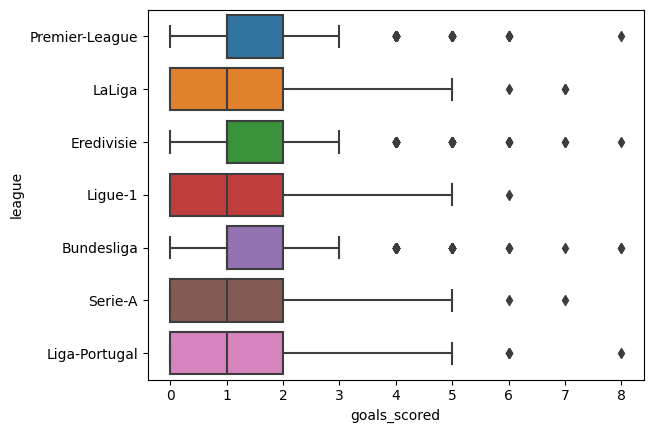

In [39]:
sns.boxplot(x=df_ml['goals_scored'],y=df_ml['league'])

While most football games result in a team scoring between 0 and 2 goals, there are rare instances where teams manage to score five or more goals.

<Axes: xlabel='xG', ylabel='league'>

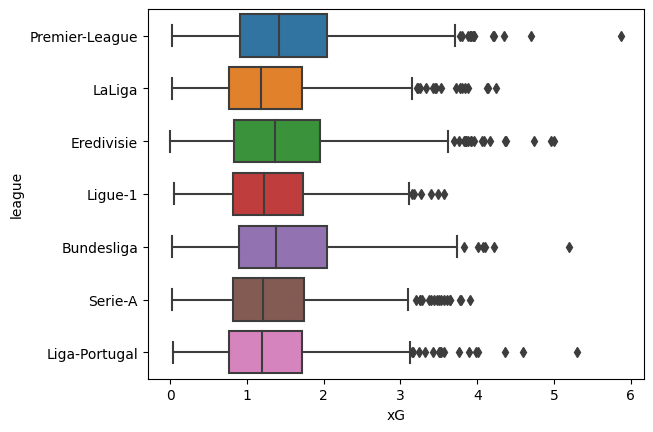

In [40]:
sns.boxplot(x=df_ml['xG'],y=df_ml['league'])

### Model Goal Scoring Probabilities Using Poisson Distribution

In [44]:
df_ml.head()

,match_id,team_id,team,goals_scored,xG,opponent,goals_conceded,xGA,xG-xGA,points,league
0,1729190,13.0,Arsenal,2.0,1.165430,Nottingham-Forest,1.0,0.511499,0.653931,3,Premier-League
1,1729454,13.0,Arsenal,2.0,1.665947,Nottingham-Forest,1.0,0.779480,0.886467,3,Premier-League
2,1729203,13.0,Arsenal,1.0,1.803739,Crystal-Palace,0.0,1.015997,0.787742,3,Premier-League
3,1729533,13.0,Arsenal,5.0,2.745248,Crystal-Palace,0.0,0.397189,2.348059,3,Premier-League
4,1729212,13.0,Arsenal,2.0,1.319473,Chelsea,2.0,1.294888,0.024585,1,Premier-League


The Poisson distribution models the probability of a given number of goals being scored based on an average rate (λ), which, in this case, is the team's total xG.

In [45]:
# Maximum number of goals to consider 
max_goals = 5 

# Calculate goal probabilities for Team A and Team B 
team_goal_probs = [poisson.pmf(i, df_ml['xG']) for i in range(max_goals + 1)] 
opponent_goal_probs = [poisson.pmf(i, df_ml['xGA']) for i in range(max_goals + 1)]

### Determine Match Outcome Probabilities based on xG

match_probs represents the probability of Team scoring x goals and conceding y goals, based on the xG and xGA on that specific game

In [46]:
match_probs = np.outer(team_goal_probs, opponent_goal_probs)

In [47]:
# Probability of Team winning (Team A scores more than Team B) 
P_win = np.sum(np.tril(match_probs, -1)) 

# Probability of a draw (both teams score the same number of goals) 
P_draw = np.sum(np.diag(match_probs)) 

# Probability of Team losing (Team A scores fewer goals than Team B) 
P_loss = np.sum(np.triu(match_probs, 1)) 

### Determine Expected Points based on match Probabilities

In [48]:
expected_points = (3 * P_win) + (1 * P_draw)

## xP Calculation Summarized

In [41]:
def calculate_xP_based_on_xG(xG,xGA,max_goals=10):
    # Calculate goal probabilities for Team A and Team B 
    team_goal_probs = [poisson.pmf(i, xG) for i in range(max_goals + 1)] 
    opponent_goal_probs = [poisson.pmf(i, xGA) for i in range(max_goals + 1)]

    match_probs = np.outer(team_goal_probs, opponent_goal_probs)

    # Probability of Team winning, drawing or losing 
    P_win = np.sum(np.tril(match_probs, -1)) 
    P_draw = np.sum(np.diag(match_probs)) 
    P_loss = np.sum(np.triu(match_probs, 1)) 

    # Expected Points calculation
    expected_points = (3 * P_win) + (1 * P_draw)

    return expected_points, P_win, P_draw, P_loss

In [42]:
# Apply the function to each row of the DataFrame and add new columns
df_ml[['expected_points', 'P_win', 'P_draw', 'P_loss']] = df_ml.apply(
    lambda row: pd.Series(calculate_xP_based_on_xG(row['xG'], row['xGA'])),
    axis=1)

In [43]:
df_ml.head()

,match_id,team_id,team,goals_scored,xG,opponent,goals_conceded,xGA,xG-xGA,points,league,expected_points,P_win,P_draw,P_loss
0,1729190,13.0,Arsenal,2.0,1.165430,Nottingham-Forest,1.0,0.511499,0.653931,3,Premier-League,1.880856,0.521572,0.316140,0.162288
1,1729454,13.0,Arsenal,2.0,1.665947,Nottingham-Forest,1.0,0.779480,0.886467,3,Premier-League,1.997388,0.585286,0.241531,0.173182
2,1729203,13.0,Arsenal,1.0,1.803739,Crystal-Palace,0.0,1.015997,0.787742,3,Premier-League,1.905824,0.558477,0.230393,0.211127
3,1729533,13.0,Arsenal,5.0,2.745248,Crystal-Palace,0.0,0.397189,2.348059,3,Premier-League,2.688566,0.861270,0.104757,0.033835
4,1729212,13.0,Arsenal,2.0,1.319473,Chelsea,2.0,1.294888,0.024585,1,Premier-League,1.385716,0.374224,0.263043,0.362732


## Score probabilities

The final score of a football game may not accurately represent the true balance of power between the teams. In this section, we will analyze the probability of each outcome based on the chances created during the game to determine if a team deserved the final result

In [44]:
selected_team = 'Bayern-Munich'
df_ml_team = df_ml[df_ml['team']==selected_team]
df_ml_team.head(10)

,match_id,team_id,team,goals_scored,xG,opponent,goals_conceded,xGA,xG-xGA,points,league,expected_points,P_win,P_draw,P_loss
2666,1743544,37.0,Bayern-Munich,1.0,2.259012,Union-Berlin,0.0,0.332860,1.926152,3,Bundesliga,2.590220,0.815841,0.142696,0.041438
2667,1743653,37.0,Bayern-Munich,5.0,1.779164,Union-Berlin,1.0,1.789927,-0.010763,3,Bundesliga,1.383231,0.387613,0.220394,0.391988
2668,1743402,37.0,Bayern-Munich,3.0,2.230621,Augsburg,1.0,0.648705,1.581917,3,Bundesliga,2.377167,0.735042,0.172040,0.092895
2669,1743515,37.0,Bayern-Munich,3.0,1.621210,Augsburg,2.0,2.534875,-0.913665,3,Bundesliga,0.901075,0.238486,0.185617,0.575826
2670,1743436,37.0,Bayern-Munich,2.0,1.741017,RB-Leipzig,2.0,1.158592,0.582424,1,Bundesliga,1.766732,0.510132,0.236335,0.253530
2671,1743571,37.0,Bayern-Munich,2.0,1.447373,RB-Leipzig,1.0,0.596404,0.850969,3,Bundesliga,2.005861,0.579309,0.267934,0.152757
2672,1743463,37.0,Bayern-Munich,8.0,4.107515,Darmstadt,0.0,0.542948,3.564567,3,Bundesliga,2.846748,0.933533,0.046149,0.016861
2673,1743624,37.0,Bayern-Munich,5.0,3.824130,Darmstadt,2.0,0.601329,3.222800,3,Bundesliga,2.800229,0.913411,0.059995,0.024570
2674,1743490,37.0,Bayern-Munich,3.0,2.517208,Hoffenheim,0.0,1.275007,1.242200,3,Bundesliga,2.110825,0.644140,0.178404,0.177390
2675,1743693,37.0,Bayern-Munich,2.0,1.230478,Hoffenheim,4.0,1.820733,-0.590255,0,Bundesliga,1.003837,0.258055,0.229671,0.512270


In [45]:
def generate_match_analysis_aligned(df_ml, match_id, max_goals=5):
    # Extract data for the specific match_id
    match_data = df_ml[df_ml['match_id'] == match_id]
    team_1 = match_data.iloc[0]['team']
    team_1_goals = int(match_data.iloc[0]['goals_scored'])  # Convert to int
    team_1_xG = match_data.iloc[0]['xG']
    
    team_2 = match_data.iloc[0]['opponent']
    team_2_goals = int(match_data.iloc[0]['goals_conceded'])  # Convert to int
    team_2_xGA = match_data.iloc[0]['xGA']
    
    P_win_team_1 = match_data.iloc[0]['P_win']
    P_draw = match_data.iloc[0]['P_draw']
    P_win_team_2 = match_data.iloc[0]['P_loss']

    # Generate Poisson probabilities
    gProbs_team_1 = [poisson.pmf(i, team_1_xG) for i in range(max_goals + 1)]
    gProbs_team_2 = [poisson.pmf(i, team_2_xGA) for i in range(max_goals + 1)]
    
    # Generate probability matrix for final score
    final_score_probs = np.outer(gProbs_team_1, gProbs_team_2)
    
    # Create the figure and gridspec layout
    fig = plt.figure(figsize=(6, 6))
    gs = fig.add_gridspec(2, 2, width_ratios=[1, 2], height_ratios=[2, 1], wspace=0.25, hspace=0.25)  # Adjusted hspace
    
    # Colors and green goal bar settings
    bar_color = '#fed9b7'  # Updated bar color
    goal_color = '#780000'  # For the actual goals
    
    # Team 1 Bar Plot (aligned with heatmap Y-axis)
    ax_bar_team_1 = fig.add_subplot(gs[0, 0])
    bars_team_1 = ax_bar_team_1.barh(range(max_goals + 1), gProbs_team_1, color=bar_color, edgecolor='black')
    bars_team_1[team_1_goals].set_color(goal_color)  # Set the actual goals bar to green
    ax_bar_team_1.set_xlim(0, max(gProbs_team_1) * 1.1)
    ax_bar_team_1.axhline(team_1_xG, color='#1b263b', linestyle='--')
    ax_bar_team_1.invert_xaxis()
    ax_bar_team_1.set_ylabel(f'{team_1} Goals')
    ax_bar_team_1.axis('off')
    
    # Add subtle percentages to each bar for Team 1
    for i, prob in enumerate(gProbs_team_1):
        ax_bar_team_1.text(prob + 0.01, i, f'{prob*100:.1f}%', va='center', ha='right', fontsize=8, color='black')

    # Team 2 Bar Plot (aligned with heatmap X-axis)
    ax_bar_team_2 = fig.add_subplot(gs[1, 1])
    bars_team_2 = ax_bar_team_2.bar(range(max_goals + 1), gProbs_team_2, color=bar_color, edgecolor='black')
    bars_team_2[team_2_goals].set_color(goal_color)  # Set the actual goals bar to green
    ax_bar_team_2.axvline(team_2_xGA, color='#1b263b', linestyle='--')
    ax_bar_team_2.set_ylim(0, max(gProbs_team_2) * 1.1)
    ax_bar_team_2.set_xlabel(f'{team_2} Goals')
    ax_bar_team_2.invert_yaxis()
    ax_bar_team_2.axis('off')
    
    # Add subtle percentages to each bar for Team 2
    for i, prob in enumerate(gProbs_team_2):
        ax_bar_team_2.text(i, prob + 0.05, f'{prob*100:.1f}%', va='bottom', ha='center', fontsize=8, color='black')
    
    # Heatmap of final score probabilities
    ax_heatmap = fig.add_subplot(gs[0, 1])
    sns.heatmap(final_score_probs, annot=True, fmt='.1%', cmap='Reds', cbar=False,
                xticklabels=range(max_goals + 1), yticklabels=range(max_goals + 1),
                ax=ax_heatmap)
    ax_heatmap.invert_yaxis()
    ax_heatmap.set_ylabel(f'{team_1} Goals')
    ax_heatmap.set_xlabel(f'{team_2} Goals')
    
    # Update plt.figtext section (adjusted y-position to prevent overlap)
    plt.figtext(0, 1, f"{team_1} {team_1_goals} ({team_1_xG:.2f} xG) vs {team_2} {team_2_goals} ({team_2_xGA:.2f} xG)",
                ha='left', fontsize=14, fontweight='bold')
    
    plt.figtext(0, 0.95, f"Probability of {team_1} win: {P_win_team_1*100:.1f}%", ha='left', fontsize=10, color='#1b4332')
    
    plt.figtext(0, 0.92, f"Probability of draw: {P_draw*100:.1f}%", ha='left', fontsize=10, color='darkgrey')
    
    plt.figtext(0, 0.89, f"Probability of {team_2} win: {P_win_team_2*100:.1f}%", ha='left', fontsize=10, color='darkred')

    plt.tight_layout()
    plt.show()

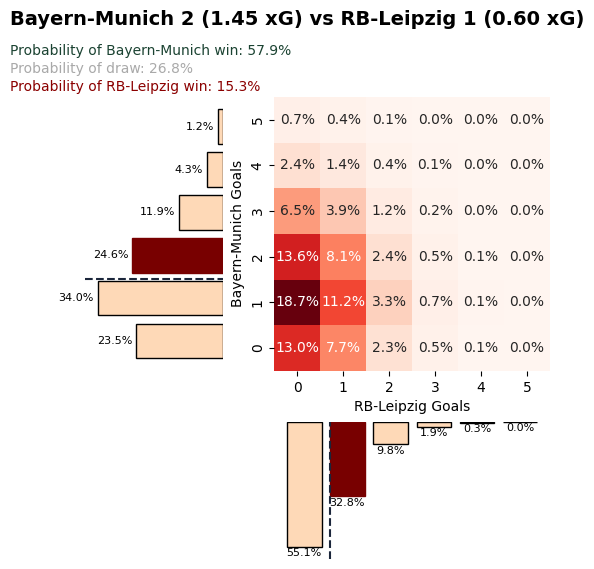

In [46]:
# Example usage
match_id = 1743571  # Replace with any match_id from your dataset
generate_match_analysis_aligned(df_ml, match_id, max_goals=5)

In this case, the final score aligns reasonably well with the expected outcome, as Bayern Munich had a 57% chance of winning. Both teams exceeded their expected goals, but Bayern Munich created more high-quality scoring opportunities. The specific scoreline of 2-1 had an 8.1% probability, which is relatively high, suggesting a fairly balanced match.

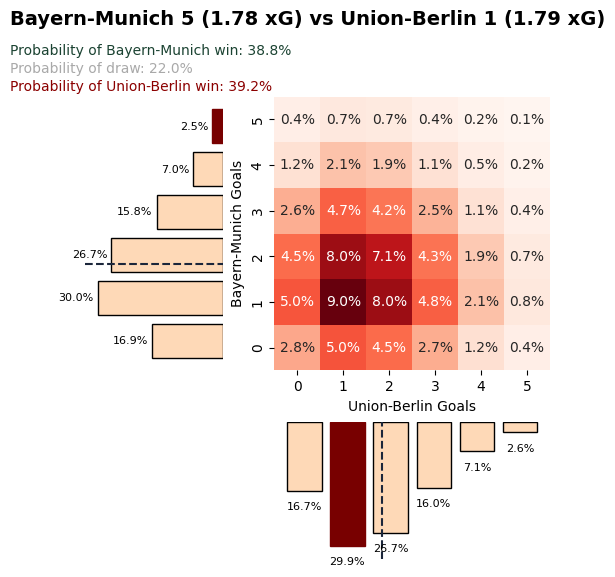

In [47]:
# Example usage
match_id = 1743653  # Replace with any match_id from your dataset
generate_match_analysis_aligned(df_ml, match_id, max_goals=5)

In this particular match, Bayern found themselves fortunate to secure a 5-1 victory. This result suggests that they were highly clinical in front of goal, coupled with a solid performance from their goalkeeper. The final scoreline, with a probability of just 0.7%, highlights how unexpected this outcome was. Scoring five goals from an xG of 1.78 is extraordinary, with only a 2.5% chance of achieving such efficiency.

This game serves as a prime example of how the final score can be misleading. For the casual observer checking the scoreline on an app like SofaScore, it might seem like a routine win for Bayern. However, the underlying stats tell a different story. The match was far more competitive than the scoreline suggests. This also illustrates a key trait of top-tier teams: their ability to secure dominant victories (in this case, a remarkable one) even in games that aren’t as straightforward as they appear.

In the next section, we will dive into the difference between Points and xP, and explore how teams investigate how teams overcome disparities between their performance and final results.

### Generate Prompt

### Huggingface Analyst

Not at all satisfied with the results; the analysis generated does not focus on the key element wanted despite a thorough and clear prompt


## Team Analysis

In [48]:
df_ml['Points-xP'] = df_ml['points']-df_ml['expected_points']

In [49]:
columns_to_sum = ['xG', 'goals_scored', 'goals_conceded', 'xGA','xG-xGA','points','expected_points','Points-xP']  

In [50]:
# Group by 'team_id' and aggregate with 'first' for 'team_name'
df_ml_grouped = df_ml.groupby('team_id').agg({
    'team': 'first',
    'league':'first',# Get the first team name
    **{col: 'sum' for col in columns_to_sum}  # Sum for other columns
}).reset_index()

# Now, sort by 'xG' in descending order
df_ml_grouped.sort_values(by='expected_points', ascending=False, inplace=True)

# Reset the index
df_ml_grouped.reset_index(drop=True, inplace=True)

In [51]:
df_ml_grouped.head()

,team_id,team,league,xG,goals_scored,goals_conceded,xGA,xG-xGA,points,expected_points,Points-xP
0,129.0,PSV-Eindhoven,Eredivisie,93.990016,111.0,21.0,27.103748,66.886269,91,80.273252,10.726748
1,13.0,Arsenal,Premier-League,79.229722,91.0,29.0,30.360062,48.869660,89,80.052827,8.947173
2,256.0,Feyenoord,Eredivisie,84.632837,92.0,26.0,20.358860,64.273978,84,79.782421,4.217579
3,167.0,Manchester-City,Premier-League,78.847878,96.0,34.0,32.949798,45.898080,91,78.306215,12.693785
4,75.0,Inter,Serie-A,77.622950,89.0,22.0,34.195375,43.427574,94,76.729555,17.270445


### Graphs

<Axes: xlabel='xG', ylabel='points'>

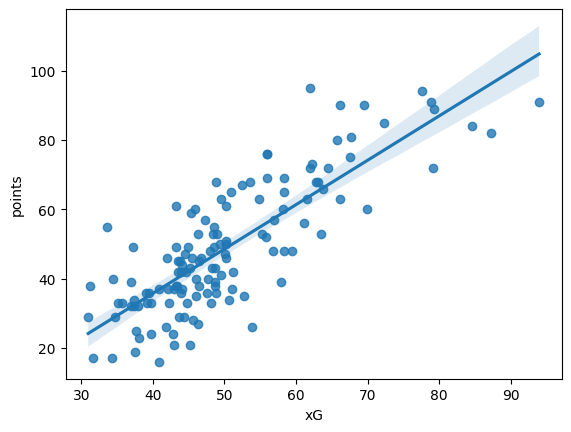

In [52]:
sns.regplot(data = df_ml_grouped ,x ='xG',y='points')

<Axes: xlabel='Points-xP', ylabel='league'>

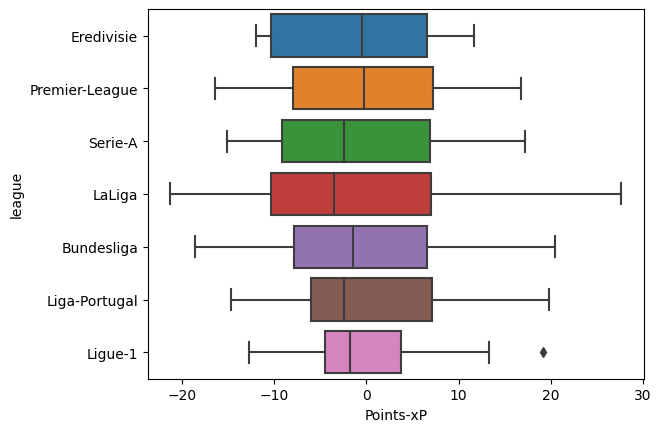

In [53]:
sns.boxplot(x=df_ml_grouped['Points-xP'],y = df_ml_grouped['league'])

<Axes: xlabel='expected_points', ylabel='points'>

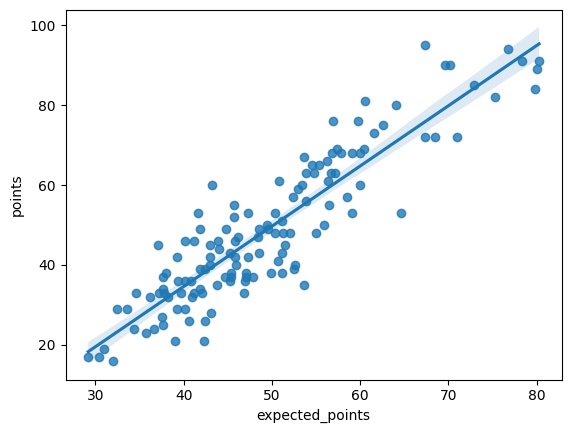

In [54]:
sns.regplot(data = df_ml_grouped ,x ='expected_points',y='points')

# Case Study 

In [55]:
query = "SELECT * FROM match_events_2024_25"
df_events_24_25 = pd.read_sql(query, engine)

In [56]:
df_events_24_25

,id,match_id,event_id,minute,second,team_id,player_id,x,y,end_x,...,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_shot,card_type,is_goal,type_display_name,outcome_type_display_name,period_display_name
0,2706932811,1822174,3,0,0.0,758,459078,49.9,50.1,49.0,...,NaN,NaN,NaN,NaN,0,0,0,Pass,Successful,FirstHalf
1,2706932861,1822174,4,0,1.0,758,444652,49.0,53.7,29.7,...,NaN,NaN,NaN,NaN,0,0,0,Pass,Successful,FirstHalf
2,2706933025,1822174,5,0,4.0,758,394980,28.0,37.7,29.5,...,NaN,NaN,NaN,NaN,0,0,0,Pass,Successful,FirstHalf
3,2706933071,1822174,6,0,16.0,758,78353,54.5,79.0,30.0,...,NaN,NaN,NaN,NaN,0,0,0,Pass,Successful,FirstHalf
4,2706933153,1822174,7,0,20.0,758,394980,26.6,56.1,31.7,...,NaN,NaN,NaN,NaN,0,0,0,Pass,Successful,FirstHalf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725860,2732606565,1836708,702,53,54.0,122,454408,62.6,93.4,NaN,...,NaN,NaN,NaN,NaN,0,0,0,Aerial,Successful,SecondHalf
725861,2732606567,1836708,895,53,54.0,107,322790,37.4,6.6,NaN,...,NaN,NaN,NaN,NaN,0,0,0,Aerial,Unsuccessful,SecondHalf
725862,2732614673,1836708,897,97,37.0,107,472910,36.9,17.9,NaN,...,NaN,NaN,NaN,NaN,0,0,0,Aerial,Successful,SecondHalf
725863,2732614675,1836708,704,97,37.0,122,389065,63.1,82.1,NaN,...,NaN,NaN,NaN,NaN,0,0,0,Aerial,Unsuccessful,SecondHalf


In [62]:
def score_per_game(df_events):
    goals_per_game = df_events.groupby(['match_id','team_id'])[['is_goal','own_goal','xG']].sum().reset_index()
    goals_per_game['is_goal'] = goals_per_game['is_goal']-goals_per_game['own_goal']
    
    goals_per_game['team_identifier'] = 'team_' + (goals_per_game.groupby('match_id').cumcount() + 1).astype(str)
    
    score_per_game = goals_per_game.pivot(index='match_id', columns='team_identifier', values=['team_id', 'is_goal', 'own_goal','xG'])
    
    score_per_game.columns = [f'{col[0]}_{col[1]}' for col in score_per_game.columns]
    
    score_per_game.reset_index(inplace=True)
    
    score_per_game.rename(columns={
        'team_id_team_1': 'team_1_id',
        'is_goal_team_1': 'team_1_goals',
        'own_goal_team_1': 'team_1_own_goals',
        'team_id_team_2': 'team_2_id',
        'is_goal_team_2': 'team_2_goals',
        'own_goal_team_2': 'team_2_own_goals',
    
    }, inplace=True)
    
    score_per_game['team_1_goals'] = score_per_game['team_1_goals'] + score_per_game['team_2_own_goals']
    score_per_game['team_2_goals'] = score_per_game['team_2_goals'] + score_per_game['team_1_own_goals']
    
    score_per_game.drop(columns=['team_1_own_goals', 'team_2_own_goals'], inplace=True)

    score_per_game = pd.merge(score_per_game, df_teams[['team_id','team_name']], left_on = 'team_1_id',right_on='team_id')
    score_per_game = pd.merge(score_per_game, df_teams[['team_id','team_name']], left_on = 'team_2_id',right_on='team_id')
    
    score_per_game = score_per_game[['match_id','team_1_id','team_2_id','team_name_x','team_name_y','team_1_goals','team_2_goals','xG_team_1','xG_team_2']]
    
    score_per_game.rename(columns={'team_name_x':'team_1_name','team_name_y':'team_2_name'},inplace=1)
        
    return score_per_game

In [63]:
def xP_calculation(df):
    df_shots1 = transform_data(df)
    df_shots1 = xG_calculation(df_shots1)
    df = pd.merge(df,df_shots1[['id','xG']],on='id',how='left')
    df['xG'].fillna(0, inplace=True)
    df['own_goal'] = np.where((df['is_goal']==1) & (df['x']<30), 1,0)
    score_per_game1 = score_per_game(df)
    df_ml1 = transform_columns_to_row(score_per_game1)
    df_ml1['points'] = df_ml1.apply(lambda row: calculate_points(row['goals_scored'], row['goals_conceded']), axis=1)
    df_ml1 = pd.merge(df_ml1,df_teams[['team_id','league']],on='team_id')
    # Apply the function to each row of the DataFrame and add new columns
    df_ml1[['expected_points', 'P_win', 'P_draw', 'P_loss']] = df_ml1.apply(
        lambda row: pd.Series(calculate_xP_based_on_xG(row['xG'], row['xGA'])),
        axis=1)
    df_ml1['Points-xP'] = df_ml1['points']-df_ml1['expected_points']
    columns_to_sum = ['xG', 'goals_scored', 'goals_conceded', 'xGA','xG-xGA','points','expected_points','Points-xP']  
    # Group by 'team_id' and aggregate with 'first' for 'team_name'
    df_ml_grouped1 = df_ml1.groupby('team_id').agg({
        'team': 'first',
        'league':'first',# Get the first team name
        **{col: 'sum' for col in columns_to_sum}  # Sum for other columns
    }).reset_index()

    df_ml_grouped1.sort_values(by='expected_points', ascending=False, inplace=True)
    df_ml_grouped1.reset_index(drop=True, inplace=True)

    return df_ml_grouped1

In [64]:
df_ml_grouped_24_25 = xP_calculation(df_events_24_25)

In [65]:
df_ml_grouped_24_25

,team_id,team,league,xG,goals_scored,goals_conceded,xGA,xG-xGA,points,expected_points,Points-xP
0,296.0,Sporting-CP,Liga-Portugal,21.558740,27.0,2.0,4.055409,17.503331,24,20.717819,3.282181
1,129.0,PSV-Eindhoven,Eredivisie,20.299093,26.0,6.0,6.341070,13.958023,21,18.285426,2.714574
2,65.0,Barcelona,LaLiga,17.054770,28.0,9.0,8.160687,8.894083,24,17.602879,6.397121
3,52.0,Real-Madrid,LaLiga,17.494861,19.0,6.0,7.990938,9.503924,21,17.175849,3.824151
4,299.0,Benfica,Liga-Portugal,14.679363,17.0,5.0,3.680715,10.998648,16,16.483762,-0.483762
...,...,...,...,...,...,...,...,...,...,...,...
127,219.0,Mainz-05,Bundesliga,6.753092,11.0,10.0,12.280992,-5.527900,8,5.402953,2.597047
128,145.0,Saint-Etienne,Ligue-1,6.296301,6.0,18.0,16.005645,-9.709344,7,5.294219,1.705781
129,311.0,Montpellier,Ligue-1,6.295210,8.0,21.0,14.107250,-7.812040,4,5.183752,-1.183752
130,1211.0,Hoffenheim,Bundesliga,7.162419,10.0,16.0,14.284625,-7.122207,4,4.908444,-0.908444


In [147]:
def league_table(df,league):
  
    df_league = df[df['league']==league]
    
    # Sort teams by actual points
    df_league['actual_position'] = df_league['points'].rank(ascending=False, method='first').astype(int)
    # Sort teams by expected points
    df_league['expected_position'] = df_league['expected_points'].rank(ascending=False, method='first').astype(int)

    df_league.sort_values(by='actual_position',ascending=True,inplace=True)
    df_league = df_league.reset_index(drop=True)

    #return df_league

    plt.figure(figsize=(10, 8))
    
    # Loop through each team
    for i in range(len(df_league)):
        # Plot the actual position in black
        plt.plot(df_league.actual_position[i], i, 'o', color="black", markersize=15)
        
        # Determine the color for expected position
        if df_league.expected_position[i] == df_league.actual_position[i]:
            color = "black"  # Actual position matches expected position
        elif df_league.expected_position[i] < df_league.actual_position[i]:
            color = "darkgreen"  # Expected position is better (smaller number)
        else:
            color = "darkred"  # Expected position is worse (larger number)
        
        # Plot the expected position with the determined color
        plt.plot(df_league.expected_position[i], i, 'o', color=color, markersize=15)
        
        # Draw a dashed line between the actual and expected positions
        plt.plot([df_league.actual_position[i], df_league.expected_position[i]], [i, i], 'o--', color="gray")

        # Add text for actual and expected positions at the corresponding points
        plt.text(df_league.actual_position[i], i, str(df_league.actual_position[i]), 
                 ha='center', va='center', fontsize=8, color='white')
        plt.text(df_league.expected_position[i], i, str(df_league.expected_position[i]), 
                 ha='center', va='center', fontsize=8, color='white')
    
    # Add team labels on the left side for actual positions
    for i in range(len(df_league)):
        plt.text(0 - 0.1, i, df_league.team[i], ha='right', va='center')



    # Add a paragraph describing the plot
    plt.text(-2, len(df_league) + 2, 
             'This plot showcases the comparison between the actual position and the expected one; how the table "should" look like based on xP', 
             ha='left', va='top', fontsize=10, wrap=True)

    
    # Set x-axis ticks to 5, 10, 15, 20
    plt.xticks([2, 4, 6, 8, 10, 12, 14, 16,18])
    
    # Hide y-axis ticks
    plt.yticks([])  
    plt.xlabel('Position')
    
    # Invert the y-axis to show higher ranks (smaller numbers) at the top
    plt.gca().invert_yaxis()
    
    # Add a title
    plt.title(f'Actual vs Expected Positions in {league}',fontweight='bold') 
    
    # Create legend
    plt.scatter([], [], color='black', label='Actual Position')
    plt.scatter([], [], color='darkgreen', label='Expected Position (Underperforming)')
    plt.scatter([], [], color='darkred', label='Expected Position (Overperforming)')
    plt.legend(loc='upper right')
    
    # Display the plot
    plt.show()

In [148]:
df_ml_grouped_24_25['league'].unique()

array(['Liga-Portugal', 'Eredivisie', 'LaLiga', 'Ligue-1',
       'Premier-League', 'Bundesliga', 'Serie-A'], dtype=object)

In [149]:
league = 'Premier-League'

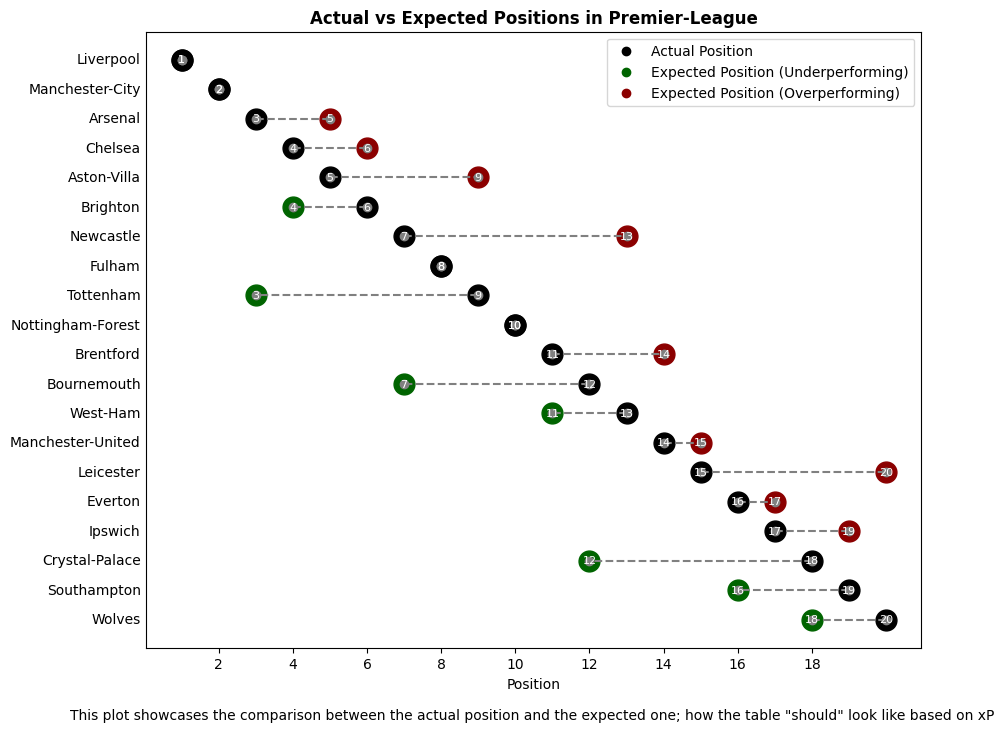

In [150]:
df_league = league_table(df_ml_grouped_24_25,league)

In [130]:
# summary

In [98]:
# scrappi

In [ ]:
# zid nb de match joué (match_id unique)

In [72]:
# bel alwen

In [73]:
# analyse par league (league positions w xG xP)
# xps 2024/25